# 🦙 **LaMa: Resolution-robust Large Mask Inpainting with Fourier Convolutions**

[[Project page](https://advimman.github.io/lama-project/)] [[GitHub](https://github.com/advimman/lama)] [[arXiv](https://arxiv.org/abs/2109.07161)] [[Supplementary](https://ashukha.com/projects/lama_21/lama_supmat_2021.pdf)] [[BibTeX](https://senya-ashukha.github.io/projects/lama_21/paper.txt)]

<p align="center" "font-size:30px;">
Our model generalizes surprisingly well to much higher resolutions (~2k❗️) than it saw during training (256x256), and achieves the excellent performance even in challenging scenarios, e.g. completion of periodic structures.
</p>

# Try it yourself!👇


In [1]:
!curl -LJO https://huggingface.co/smartywu/big-lama/resolve/main/big-lama.zip


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1169  100  1169    0     0   4783      0 --:--:-- --:--:-- --:--:--  4790
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
curl: (23) Failed writing header


In [2]:
!unzip ./big-lama.zip

Archive:  ./big-lama.zip
  inflating: big-lama/config.yaml    
  inflating: big-lama/models/best.ckpt  


In [7]:
print('\n> Install dependencies')
!pip install wldhx.yadisk-direct -q
!pip install --upgrade pip -q
!pip uninstall --yes --quiet osqp
!pip install -U scikit-survival -q
!pip uninstall kornia -y
!pip install kornia --no-dependencies -q
!pip install kornia-rs -q
!pip install pytorch-lightning -q
!pip install hydra-core==1.1.1 -q
!pip install webdataset -q
!pip install torch torchvision torchaudio torchtext -q
!pip install wget --quiet
!pip install albumentations==1.3.0 -q


> Install dependencies
Found existing installation: kornia 0.7.4
Uninstalling kornia-0.7.4:
  Successfully uninstalled kornia-0.7.4


In [4]:
#@title Run this sell to set everything up
print('\n> Cloning the repo')
!git clone https://github.com/advimman/lama.git


> Cloning the repo
Cloning into 'lama'...
remote: Enumerating objects: 469, done.
remote: Counting objects: 100% (269/269), done.
remote: Compressing objects: 100% (161/161), done.
remote: Total 469 (delta 148), reused 109 (delta 108), pack-reused 200 (from 1)
Receiving objects: 100% (469/469), 8.83 MiB | 15.54 MiB/s, done.
Resolving deltas: 100% (186/186), done.


In [ ]:
print('\n> Init mask-drawing code')
import base64, os
from IPython.display import HTML, Image
from google.colab.output import eval_js
from base64 import b64decode
# from albumentations import DualIAATransform
import matplotlib.pyplot as plt
import numpy as np
import wget
from shutil import copyfile
import shutil
import cv2


> Init mask-drawing code


In [11]:
canvas_html = """
<style>
.button {
  background-color: #4CAF50;
  border: none;
  color: white;
  padding: 15px 32px;
  text-align: center;
  text-decoration: none;
  display: inline-block;
  font-size: 16px;
  margin: 4px 2px;
  cursor: pointer;
}
</style>
<canvas1 width=%d height=%d>
</canvas1>
<canvas width=%d height=%d>
</canvas>

<button class="button">Finish</button>
<script>
var canvas = document.querySelector('canvas')
var ctx = canvas.getContext('2d')

var canvas1 = document.querySelector('canvas1')
var ctx1 = canvas.getContext('2d')


ctx.strokeStyle = 'red';

var img = new Image();
img.src = "data:image/%s;charset=utf-8;base64,%s";
console.log(img)
img.onload = function() {
  ctx1.drawImage(img, 0, 0);
};
img.crossOrigin = 'Anonymous';

ctx.clearRect(0, 0, canvas.width, canvas.height);

ctx.lineWidth = %d
var button = document.querySelector('button')
var mouse = {x: 0, y: 0}

canvas.addEventListener('mousemove', function(e) {
  mouse.x = e.pageX - this.offsetLeft
  mouse.y = e.pageY - this.offsetTop
})
canvas.onmousedown = ()=>{
  ctx.beginPath()
  ctx.moveTo(mouse.x, mouse.y)
  canvas.addEventListener('mousemove', onPaint)
}
canvas.onmouseup = ()=>{
  canvas.removeEventListener('mousemove', onPaint)
}
var onPaint = ()=>{
  ctx.lineTo(mouse.x, mouse.y)
  ctx.stroke()
}

var data = new Promise(resolve=>{
  button.onclick = ()=>{
    resolve(canvas.toDataURL('image/png'))
  }
})
</script>
"""

def draw(imgm, filename='drawing.png', w=400, h=200, line_width=1):
  display(HTML(canvas_html % (w, h, w,h, filename.split('.')[-1], imgm, line_width)))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)

In [14]:
# fname = None
# fname = 'https://ic.pics.livejournal.com/mostovoy/28566193/1224276/1224276_original.jpg' # <-in the example
fname = 'https://raw.githubusercontent.com/senya-ashukha/senya-ashukha.github.io/master/images/1010286.jpeg'
# fname = 'https://raw.githubusercontent.com/senya-ashukha/senya-ashukha.github.io/master/images/1010287.jpeg'
# fname = "https://raw.githubusercontent.com/senya-ashukha/senya-ashukha.github.io/master/images/alex.jpg"

#@title Draw a Mask, Press Finish, Wait for Inpainting

import os
# os.chdir("/content")
!PYTHONPATH=. TORCH_HOME=$(pwd)
!pwd

if fname is None:
  from google.colab import files
  files = files.upload()
  fname = list(files.keys())[0]
else:
  fname = wget.download(fname)

shutil.rmtree('./data_for_prediction', ignore_errors=True)
!mkdir data_for_prediction

copyfile(fname, f'./data_for_prediction/{fname}')
os.remove(fname)
fname = f'./data_for_prediction/{fname}'

image64 = base64.b64encode(open(fname, 'rb').read())
image64 = image64.decode('utf-8')

print(f'Will use {fname} for inpainting')
img = np.array(plt.imread(f'{fname}')[:,:,:3])

draw(image64, filename=f"./{fname.split('.')[1]}_mask.png", w=img.shape[1], h=img.shape[0], line_width=0.04*img.shape[1])
#@title Show a masked image and save a mask
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,5)
plt.rcParams['figure.dpi'] = 200
plt.subplot(131)
with_mask = np.array(plt.imread(f"./{fname.split('.')[1]}_mask.png")[:,:,:3])
mask = (with_mask[:,:,0]==1)*(with_mask[:,:,1]==0)*(with_mask[:,:,2]==0)
plt.imshow(mask, cmap='gray')
plt.axis('off')
plt.title('mask')
plt.imsave(f"./{fname.split('.')[1]}_mask.png",mask, cmap='gray')

plt.subplot(132)
img = np.array(plt.imread(f'{fname}')[:,:,:3])
plt.imshow(img)
plt.axis('off')
plt.title('img')

plt.subplot(133)
img = np.array((1-mask.reshape(mask.shape[0], mask.shape[1], -1))*plt.imread(fname)[:,:,:3])
_=plt.imshow(img)
_=plt.axis('off')
_=plt.title('img * mask')
plt.show()

/home/sangho/ML/competition/image2024
Will use ./data_for_prediction/1010286.jpeg for inpainting


NameError: name 'eval_js' is not defined

/content/lama
Run inpainting
/content/lama/saicinpainting/training/trainers/__init__.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(path, map_locati

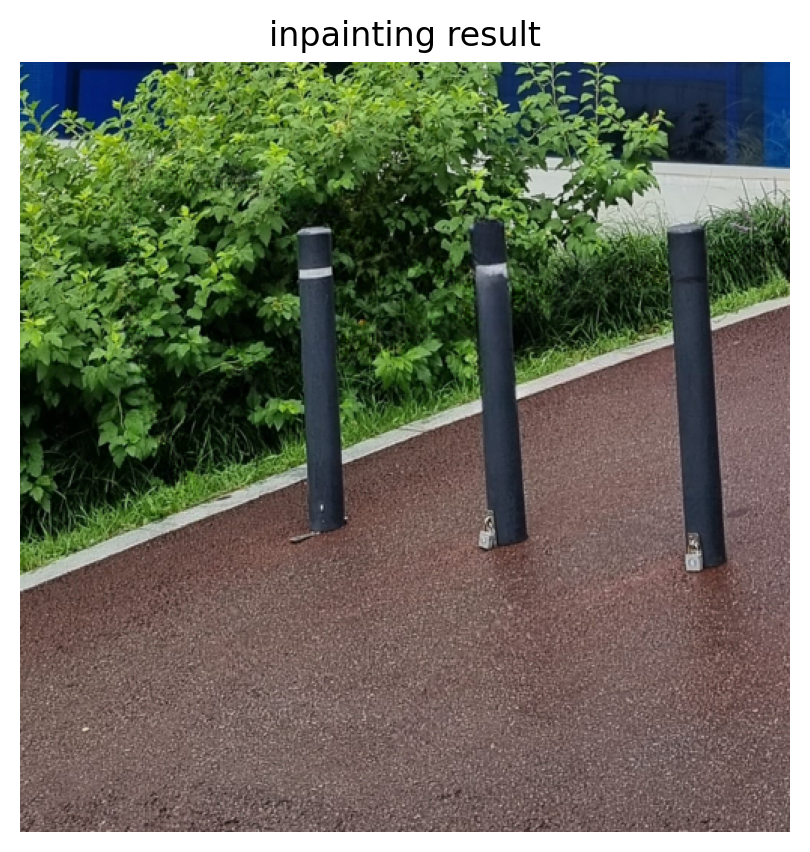

In [53]:
import os
os.chdir("lama")
!PYTHONPATH=. TORCH_HOME=$(pwd)
!pwd

print('Run inpainting')
if '.jpeg' in fname:
  !PYTHONPATH=. TORCH_HOME=$(pwd) python3 bin/predict.py model.path=/content/big-lama indir=/content/data_for_prediction outdir=/content/output dataset.img_suffix=.jpeg > /dev/null
elif '.jpg' in fname:
  !PYTHONPATH=. TORCH_HOME=$(pwd) python3 bin/predict.py model.path=/content/big-lama indir=/content/data_for_prediction outdir=/content/output  dataset.img_suffix=.jpg > /dev/null
elif '.png' in fname:
  !PYTHONPATH=. TORCH_HOME=$(pwd) python3 bin/predict.py model.path=/content/big-lama indir=/content/data_for_prediction outdir=/content/output  dataset.img_suffix=.png > /dev/null
else:
  print(f'Error: unknown suffix .{fname.split(".")[-1]} use [.png, .jpeg, .jpg]')

plt.rcParams['figure.dpi'] = 200
plt.imshow(plt.imread(f"/content/output/{fname.split('.')[1].split('/')[2]}_mask.png"))
_=plt.axis('off')
_=plt.title('inpainting result')
plt.show()
fname = None